##  CIFAR-10

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras 
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## ResNet 기본 블록 구성하기

In [3]:
def identity_block(input_tensor, num_cnn, is_50, is_skip, channel, stage):
    bn_axis = 3
    x = input_tensor
    for i, cnn_num in enumerate(range(num_cnn)):  
        conv_name_base = 'stage' + str(stage+2) +'_'+ str(i+2) +'_'
        
        if is_50 is False:
            input_tensor = x
            x = layers.Conv2D(channel, (3,3),
                          padding='same',
                          kernel_initializer='he_normal',
                          name=conv_name_base + 'conv1')(x)
            x = layers.BatchNormalization(axis=bn_axis, name=conv_name_base + 'bn1')(x)
            x = layers.Activation('relu')(x)
            
            x = layers.Conv2D(channel, (3,3),
                              padding='same',
                              kernel_initializer='he_normal',
                              name=conv_name_base + 'conv2')(x)
            x = layers.BatchNormalization(axis=bn_axis, name=conv_name_base + 'bn2')(x)
            x = layers.Activation('relu')(x)
        
        elif is_50 is True:
            input_tensor = x 
            x = layers.Conv2D(channel, (1, 1),
                              kernel_initializer='he_normal',
                              name=conv_name_base + 'conv1')(input_tensor)
            x = layers.BatchNormalization(axis=bn_axis, name=conv_name_base + 'bn1')(x)
            x = layers.Activation('relu')(x)

            x = layers.Conv2D(channel, (3,3),
                              padding='same',
                              kernel_initializer='he_normal',
                              name=conv_name_base + 'conv2')(x)
            x = layers.BatchNormalization(axis=bn_axis, name=conv_name_base + 'bn2')(x)
            x = layers.Activation('relu')(x)

            x = layers.Conv2D(channel*4, (1, 1),
                              kernel_initializer='he_normal',
                              name=conv_name_base + 'conv3')(x)
            x = layers.BatchNormalization(axis=bn_axis, name=conv_name_base + 'bn3')(x)
            x = layers.Activation('relu')(x)
            
        if is_skip is True:
            x = layers.add([x, input_tensor], name=conv_name_base+'add')
        x = layers.Activation('relu')(x)
    return x


In [4]:
def conv_block(input_tensor, is_50, is_skip, channel, stage):
    conv_name_base = 'stage' + str(stage+2) + '_1_'
    bn_axis = 3
    if stage is 0:
        strides=(1,1)
    else:
        strides=(2,2)
        
    if is_50 is False:
        x = layers.Conv2D(channel, (3,3), strides=strides, padding='same', 
                          kernel_initializer='he_normal',
                          name=conv_name_base + 'conv1')(input_tensor)
        x = layers.BatchNormalization(axis=bn_axis, name=conv_name_base + 'bn1')(x)
        x = layers.Activation('relu')(x)
        
        x = layers.Conv2D(channel, (3,3), padding='same',
                          kernel_initializer='he_normal',
                          name=conv_name_base + 'conv2')(x)
        x = layers.BatchNormalization(axis=bn_axis, name=conv_name_base + 'bn2')(x)
        x = layers.Activation('relu')(x)
        
        shortcut = layers.Conv2D(channel, (1, 1), strides=strides,padding='same', 
                                 kernel_initializer='he_normal',
                                 name=conv_name_base + 'short')(input_tensor)
        shortcut = layers.BatchNormalization(
            axis=bn_axis, name=conv_name_base + 'bn3')(shortcut)
        
    elif is_50 is True:
        x = layers.Conv2D(channel, (1, 1), strides=strides,
                          kernel_initializer='he_normal',
                          name=conv_name_base + 'conv1')(input_tensor)
        x = layers.BatchNormalization(axis=bn_axis, name=conv_name_base + 'bn1')(x)
        x = layers.Activation('relu')(x)

        x = layers.Conv2D(channel, (3,3), padding='same',
                          kernel_initializer='he_normal',
                          name=conv_name_base + 'conv2')(x)
        x = layers.BatchNormalization(axis=bn_axis, name=conv_name_base + 'bn2')(x)
        x = layers.Activation('relu')(x)

        x = layers.Conv2D(channel*4, (1, 1),
                          kernel_initializer='he_normal',
                          name=conv_name_base + 'conv3')(x)
        x = layers.BatchNormalization(axis=bn_axis, name=conv_name_base + 'bn3')(x)
        x = layers.Activation('relu')(x)
        
        shortcut = layers.Conv2D(channel*4, (1, 1), strides=strides,
                                 kernel_initializer='he_normal',
                                 name=conv_name_base + 'short')(input_tensor)
        shortcut = layers.BatchNormalization(
            axis=bn_axis, name=conv_name_base + 'bn4')(shortcut)
        
    if is_skip is True:
        x = layers.add([x, shortcut], name=conv_name_base+'add')
        x = layers.Activation('relu')(x)
    return x

In [5]:
def build_resnet(input_shape=(32,32,3),
                   num_cnn_list=[2,3,5,2],
                   channel_list=[64,128,256,512],
                   is_50=False,
                   is_skip=True,
                   num_classes=10):
    assert len(num_cnn_list) is len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape, name='input_layer')
    output = input_layer
    
    output = layers.Conv2D(64, kernel_size=(7, 7), strides=(2,2), 
                           padding='same', name='stage1_1_conv1')(output)
    output = layers.BatchNormalization(name='stage1_1_bn1')(output)
    output = layers.Activation('relu')(output)
    
    output = layers.MaxPool2D(pool_size=(2,2), strides=2, name='stage2_0_maxpooling')(output)
    
    for i, (channel, num_cnn) in enumerate(zip(channel_list, num_cnn_list)):
        output = conv_block(
            output,
            is_50=is_50,
            is_skip=is_skip,
            channel=channel,
            stage = i
        )

        output = identity_block(
            output,
            num_cnn=num_cnn, 
            is_50=is_50,
            is_skip=is_skip,
            channel=channel, 
            stage = i
        )
        
    
    output = layers.AveragePooling2D(pool_size=(1, 1), name='avg_pool')(output)
    output = layers.Flatten()(output)
    output = layers.Dense(num_classes, activation='softmax', name='fc1000')(output)
    
    model = keras.Model(inputs=input_layer, outputs=output)
    return model
    
    

## ResNet-34, ResNet-50 Complete Model

In [6]:
resnet_34 = build_resnet(input_shape=(32, 32,3), is_50=False)
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
stage1_1_conv1 (Conv2D)         (None, 16, 16, 64)   9472        input_layer[0][0]                
__________________________________________________________________________________________________
stage1_1_bn1 (BatchNormalizatio (None, 16, 16, 64)   256         stage1_1_conv1[0][0]             
__________________________________________________________________________________________________
activation (Activation)         (None, 16, 16, 64)   0           stage1_1_bn1[0][0]               
______________________________________________________________________________________________

In [7]:
resnet_50 = build_resnet(input_shape=(32, 32,3), is_50=True)
resnet_50.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
stage1_1_conv1 (Conv2D)         (None, 16, 16, 64)   9472        input_layer[0][0]                
__________________________________________________________________________________________________
stage1_1_bn1 (BatchNormalizatio (None, 16, 16, 64)   256         stage1_1_conv1[0][0]             
__________________________________________________________________________________________________
activation_49 (Activation)      (None, 16, 16, 64)   0           stage1_1_bn1[0][0]               
____________________________________________________________________________________________

## Ablation Study를 위한 (224, 224, 3) 입력 모델 만들기

In [8]:
resnet_34 = build_resnet(input_shape=(224, 224,3), is_50=False, is_skip=True)
resnet_34.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stage1_1_conv1 (Conv2D)         (None, 112, 112, 64) 9472        input_layer[0][0]                
__________________________________________________________________________________________________
stage1_1_bn1 (BatchNormalizatio (None, 112, 112, 64) 256         stage1_1_conv1[0][0]             
__________________________________________________________________________________________________
activation_114 (Activation)     (None, 112, 112, 64) 0           stage1_1_bn1[0][0]               
____________________________________________________________________________________________

In [9]:
resnet_50 = build_resnet(input_shape=(224, 224,3), is_50=True, is_skip=True)
resnet_50.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stage1_1_conv1 (Conv2D)         (None, 112, 112, 64) 9472        input_layer[0][0]                
__________________________________________________________________________________________________
stage1_1_bn1 (BatchNormalizatio (None, 112, 112, 64) 256         stage1_1_conv1[0][0]             
__________________________________________________________________________________________________
activation_163 (Activation)     (None, 112, 112, 64) 0           stage1_1_bn1[0][0]               
____________________________________________________________________________________________

## 일반 네트워크(plain network) 만들기

In [10]:
plain_34 = build_resnet(input_shape=(224, 224,3), is_50=False, is_skip=False)
plain_34.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
stage1_1_conv1 (Conv2D)      (None, 112, 112, 64)      9472      
_________________________________________________________________
stage1_1_bn1 (BatchNormaliza (None, 112, 112, 64)      256       
_________________________________________________________________
activation_228 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
stage2_0_maxpooling (MaxPool (None, 56, 56, 64)        0         
_________________________________________________________________
stage2_1_conv1 (Conv2D)      (None, 56, 56, 64)        36928     
_________________________________________________________________
stage2_1_bn1 (BatchNormaliza (None, 56, 56, 64)        256 

In [11]:
plain_50 = build_resnet(input_shape=(224, 224,3), is_50=True, is_skip=False)
plain_50.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
stage1_1_conv1 (Conv2D)      (None, 112, 112, 64)      9472      
_________________________________________________________________
stage1_1_bn1 (BatchNormaliza (None, 112, 112, 64)      256       
_________________________________________________________________
activation_273 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
stage2_0_maxpooling (MaxPool (None, 56, 56, 64)        0         
_________________________________________________________________
stage2_1_conv1 (Conv2D)      (None, 56, 56, 64)        4160      
_________________________________________________________________
stage2_1_bn1 (BatchNormaliza (None, 56, 56, 64)        256 

## ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34

In [12]:
BATCH_SIZE = 32
EPOCH = 15

### Input Normalization

In [13]:
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, (224, 224))
    return tf.cast(image, tf.float32) / 255., label

In [14]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [15]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    with_info=True,
)

In [16]:
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [17]:
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [18]:
ds_info.features["label"].names

['cat', 'dog']

In [19]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})

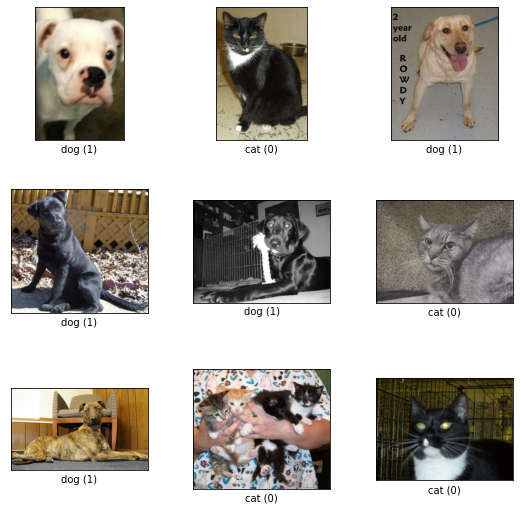

In [20]:
fig = tfds.show_examples(ds_train, ds_info)

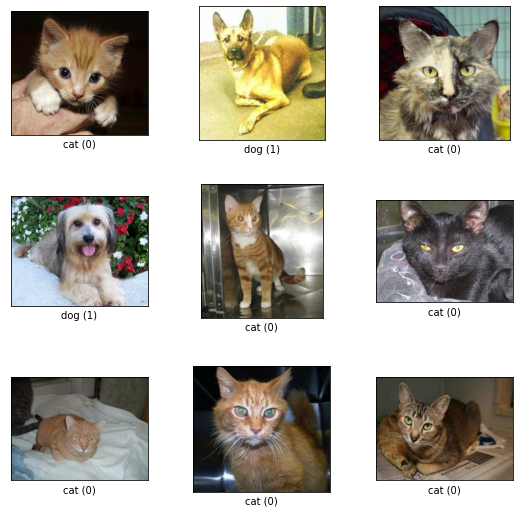

In [21]:
fig = tfds.show_examples(ds_test, ds_info)

In [22]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    with_info=True,
    as_supervised=True
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [21]:
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
581/581 [==============================] - 98s 168ms/step - loss: 1.0633 - accuracy: 0.5748 - val_loss: 2.2705 - val_accuracy: 0.5278
Epoch 2/15
581/581 [==============================] - 137s 236ms/step - loss: 0.8910 - accuracy: 0.6234 - val_loss: 1.0608 - val_accuracy: 0.6316
Epoch 3/15
581/581 [==============================] - 97s 167ms/step - loss: 0.8142 - accuracy: 0.6659 - val_loss: 0.9745 - val_accuracy: 0.6640
Epoch 4/15
581/581 [==============================] - 97s 167ms/step - loss: 0.7413 - accuracy: 0.7080 - val_loss: 0.8246 - val_accuracy: 0.6558
Epoch 5/15
581/581 [==============================] - 97s 168ms/step - loss: 0.6498 - accuracy: 0.7410 - val_loss: 0.7701 - val_accuracy: 0.7073
Epoch 6/15
581/581 [==============================] - 97s 168ms/step - loss: 0.5787 - accuracy: 0.7691 - val_loss: 0.8632 - val_accuracy: 0.6690
Epoch 7/15
581/581 [==============================] - 97s 168ms/step - loss: 0.5042 - accuracy: 0.7967 - val_loss: 0.7895 - val_a

In [22]:
plain_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_34 = plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
581/581 [==============================] - 85s 147ms/step - loss: 0.8261 - accuracy: 0.5232 - val_loss: 1.6799 - val_accuracy: 0.5102
Epoch 2/15
581/581 [==============================] - 85s 146ms/step - loss: 0.7842 - accuracy: 0.5329 - val_loss: 4.7619 - val_accuracy: 0.4801
Epoch 3/15
581/581 [==============================] - 86s 148ms/step - loss: 0.7825 - accuracy: 0.5145 - val_loss: 0.9214 - val_accuracy: 0.5204
Epoch 4/15
581/581 [==============================] - 87s 150ms/step - loss: 0.7711 - accuracy: 0.5170 - val_loss: 4.5778 - val_accuracy: 0.4874
Epoch 5/15
581/581 [==============================] - 85s 146ms/step - loss: 0.7627 - accuracy: 0.5197 - val_loss: 1.8600 - val_accuracy: 0.5022
Epoch 6/15
581/581 [==============================] - 88s 151ms/step - loss: 0.7595 - accuracy: 0.5191 - val_loss: 0.7652 - val_accuracy: 0.5426
Epoch 7/15
581/581 [==============================] - 86s 149ms/step - loss: 0.7477 - accuracy: 0.5254 - val_loss: 0.9926 - val_ac

In [23]:
resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
581/581 [==============================] - 193s 332ms/step - loss: 1.5227 - accuracy: 0.5290 - val_loss: 4.8124 - val_accuracy: 0.5228
Epoch 2/15
581/581 [==============================] - 235s 404ms/step - loss: 1.3639 - accuracy: 0.5526 - val_loss: 4.6635 - val_accuracy: 0.5195
Epoch 3/15
581/581 [==============================] - 169s 291ms/step - loss: 1.1834 - accuracy: 0.5815 - val_loss: 1.9907 - val_accuracy: 0.5425
Epoch 4/15
581/581 [==============================] - 169s 291ms/step - loss: 1.0963 - accuracy: 0.5996 - val_loss: 1.0748 - val_accuracy: 0.6035
Epoch 5/15
581/581 [==============================] - 163s 280ms/step - loss: 1.0336 - accuracy: 0.6173 - val_loss: 1.1737 - val_accuracy: 0.6032
Epoch 6/15
581/581 [==============================] - 173s 298ms/step - loss: 0.9915 - accuracy: 0.6339 - val_loss: 0.8949 - val_accuracy: 0.6481
Epoch 7/15
581/581 [==============================] - 163s 281ms/step - loss: 0.9665 - accuracy: 0.6506 - val_loss: 1.0182 -

In [24]:
plain_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_50 = plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
581/581 [==============================] - 317s 546ms/step - loss: 0.8572 - accuracy: 0.5172 - val_loss: 0.7572 - val_accuracy: 0.4961
Epoch 2/15
581/581 [==============================] - 122s 211ms/step - loss: 0.8330 - accuracy: 0.5195 - val_loss: 2.0509 - val_accuracy: 0.4812
Epoch 3/15
581/581 [==============================] - 123s 211ms/step - loss: 0.8499 - accuracy: 0.5116 - val_loss: 1.2535 - val_accuracy: 0.5262
Epoch 4/15
581/581 [==============================] - 123s 211ms/step - loss: 0.8407 - accuracy: 0.5187 - val_loss: 0.8311 - val_accuracy: 0.5091
Epoch 5/15
581/581 [==============================] - 123s 211ms/step - loss: 0.8372 - accuracy: 0.5192 - val_loss: 0.8149 - val_accuracy: 0.5291
Epoch 6/15
581/581 [==============================] - 127s 219ms/step - loss: 0.8238 - accuracy: 0.5257 - val_loss: 1.1432 - val_accuracy: 0.5325
Epoch 7/15
581/581 [==============================] - 132s 228ms/step - loss: 0.8340 - accuracy: 0.5091 - val_loss: 1.0210 -

In [44]:
# with open('./new_data/data.npy', 'wb') as f:
#     np.save(f, history_resnet_34.history['loss'])
#     np.save(f, history_resnet_34.history['val_accuracy'])
#     np.save(f, history_plain_34.history['loss'])
#     np.save(f, history_plain_34.history['val_accuracy'])
#     np.save(f, history_resnet_50.history['loss'])
#     np.save(f, history_resnet_50.history['val_accuracy'])
#     np.save(f, history_plain_50.history['loss'])
#     np.save(f, history_plain_50.history['val_accuracy'])

In [26]:
with open('./new_data/data.npy', 'rb') as f:
    history_resnet_34_loss= np.load(f)
    history_resnet_34_val_accuracy = np.load(f)
    history_plain_34_loss = np.load(f)
    history_plain_34_val_accuracy = np.load(f)

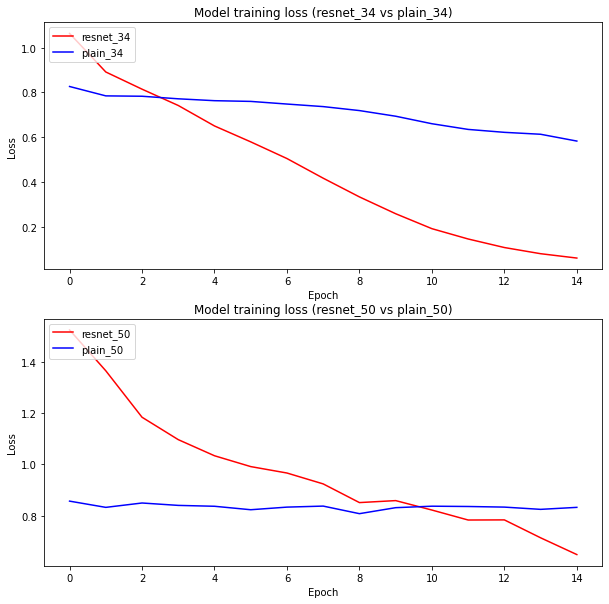

In [27]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(history_resnet_34_loss, 'r')
plt.plot(history_plain_34_loss, 'b')
plt.title('Model training loss (resnet_34 vs plain_34)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')

plt.subplot(2, 1, 2)
plt.plot(history_resnet_50.history['loss'], 'r')
plt.plot(history_plain_50.history['loss'], 'b')
plt.title('Model training loss (resnet_50 vs plain_50)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')

plt.show()

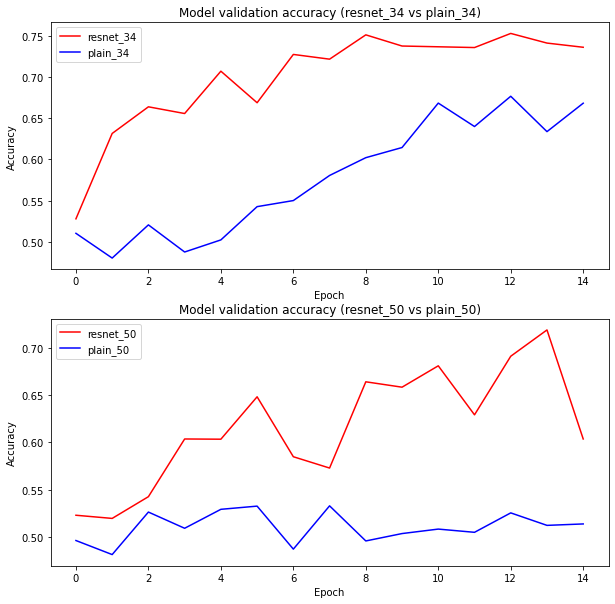

In [28]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(history_resnet_34_val_accuracy, 'r')
plt.plot(history_plain_34_val_accuracy, 'b')
plt.title('Model validation accuracy (resnet_34 vs plain_34)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')

plt.subplot(2, 1, 2)
plt.plot(history_resnet_50.history['val_accuracy'], 'r')
plt.plot(history_plain_50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy (resnet_50 vs plain_50)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')
plt.show()

## Report

|model    |Loss  |Acc.|
|:---------:|:-----:|:-----:|
|resnet_34| 0.0595  |  **0.7364**  |
|plain_34 | 0.5823| 0.6684  |
|resnet_50| 0.6495   | **0.6035** | 
|plain_50 | 0.8330  | 0.5136 | 

Ablation Study 결과표 작성 결과 skip connection의 유무가 모델의 성능에 얼마나 큰 영향을 주는 지 알게 되었다. skip connection이 없는 plain network의 경우에는 이미 saturation되어 정확도가 더이상 올라가지 않는 모습을 확인할 수 있다. Loss 그래프를 보더라도 resnet모델의 loss가 더 안정적으로 수렴된다.  
<br>
그런데 위의 그래프에서 resnet-50의 모델이 resnet-34 모델보다 성능이 떨어져보인다. 이는 optimizer와 fit에서 별다른 처리(?)를 하지 않아서 그런 것 같다. optimizer에 변화를 주고 callback 파라미터를 사용해서 모델의 성능을 높인다면 깊은 depth의 네트워크에도 좋은 성능을 가지는 Resnet의 논문 내용이 입증 될 것이다.